In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pickle
import sklearn
from sklearn.utils import class_weight
import time
from sklearn import metrics
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%run SharedFunctions.ipynb

Učitava se prethodno pripremljen skup podataka: 

In [3]:
data = pd.read_csv('data/data_longer.csv')
data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
data.shape

(223453, 9)

### 1. Podela na trening, test, i validacioni skup

In [5]:
# Ovo je prepisano iz prethodne sveske

train_size = 159571 - 96
test_size = 63978
validation_size = int(0.2*train_size)
train_size = train_size - validation_size

validation_data = data[:validation_size]
train_data = data[validation_size:train_size+validation_size]
test_data = data[train_size+validation_size : ]

train_data.shape[0], test_data.shape[0], validation_data.shape[0]

(127580, 63978, 31895)

### 2. Tokenizacija I vektorizacija teksta

In [6]:
# uzima se recimo 20000 najfrekventinijh reci
max_features = 20000

# max duzina
max_len = 100

In [7]:
word_index, tokenizer = get_vocabulary(max_features, train_data, 'tokenizer_binary.pickle')

In [8]:
print('Broj jedinstvenih reci:', len(word_index))

Broj jedinstvenih reci: 187048


Sada pravimo skupove za trening, test i validaciju sa vektorizovanim tekstom

In [9]:
X_train = to_sequence(train_data['comment_text'], max_len, tokenizer)
X_test = to_sequence(test_data['comment_text'], max_len, tokenizer)
X_validation = to_sequence(validation_data['comment_text'], max_len, tokenizer)

In [10]:
X_train.shape, X_test.shape, X_validation.shape

((127580, 100), (63978, 100), (31895, 100))

In [11]:
y_train = train_data['target']
y_test = test_data['target']
y_validation = validation_data['target']

Kreira se matrica ugnjezdavanja

In [12]:
embedding_matrix = create_embedding_matrix(word_index, max_len)

In [13]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ...,
       [-0.25132999, -0.38620001,  0.37869999, ...,  0.031966  ,
        -0.27360001, -0.96281999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.085656  , -0.22007   ,  0.75664997, ...,  0.73556   ,
         0.65118998, -0.23041999]])

### 3. Formiranje modela

In [14]:
kernel_size = 3
pool_size = 3
filters = 64
dropout_rate = 0.4

In [15]:
binary_model = create_model(num_of_classes = 2, num_of_features = max_features, embedding_dim = 100, 
                kernel_size = kernel_size, pool_size = pool_size, filters = filters, 
                dropout_rate = dropout_rate, maxlen = max_len, embedding_matrix = embedding_matrix)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 64)           19264     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 33, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 33, 64)            12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
dropout (Dropout)            (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0

In [16]:
lr = 0.001

binary_model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=[f1_m, recall_m, precision_m])

### 4. Obučavanje modela

In [17]:
weights = get_weights(y_train)
weights

{0: 0.5563210772343543, 1: 4.9388355528027255}

In [18]:
epochs = 10
batch_size = 128

In [19]:
start = time.time()    

binary_history = binary_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                                 validation_data=(X_validation, y_validation), class_weight=weights)
                                 #,callbacks=[early_stop]
                                 
print('Trajanje obucavanja modela binarne klasifikacije: ', time.time() - start)

Epoch 1/10
997/997 [==============================] - 28s 28ms/step - loss: 0.3524 - f1_m: 0.5770 - recall_m: 0.8398 - precision_m: 0.4605 - val_loss: 0.2605 - val_f1_m: 0.6716 - val_recall_m: 0.8564 - val_precision_m: 0.5613
Epoch 2/10
997/997 [==============================] - 30s 30ms/step - loss: 0.2693 - f1_m: 0.6654 - recall_m: 0.8717 - precision_m: 0.5517 - val_loss: 0.2507 - val_f1_m: 0.6804 - val_recall_m: 0.8812 - val_precision_m: 0.5627
Epoch 3/10
997/997 [==============================] - 29s 29ms/step - loss: 0.2488 - f1_m: 0.6789 - recall_m: 0.8797 - precision_m: 0.5661 - val_loss: 0.1751 - val_f1_m: 0.7404 - val_recall_m: 0.8183 - val_precision_m: 0.6860
Epoch 4/10
997/997 [==============================] - 30s 30ms/step - loss: 0.2303 - f1_m: 0.6998 - recall_m: 0.8952 - precision_m: 0.5878 - val_loss: 0.1598 - val_f1_m: 0.7553 - val_recall_m: 0.7994 - val_precision_m: 0.7265
Epoch 5/10
997/997 [==============================] - 29s 29ms/step - loss: 0.2173 - f1_m: 0.714

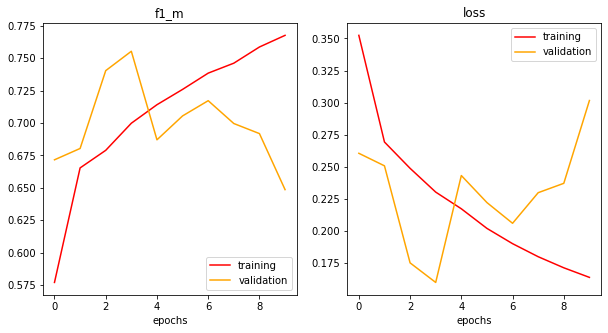

In [20]:
plot_graphs(binary_history, ['f1_m', 'loss'])

### 5. Evaluacija modela

In [21]:
scores = binary_model.evaluate(X_test, y_test)

2000/2000 [==============================] - 6s 3ms/step - loss: 0.6655 - f1_m: 0.4931 - recall_m: 0.9100 - precision_m: 0.3560A: 4s - loss: 0.6633 - f1_m: 0.4846 - recall_m: 0.9126 - pre - ETA: 3s - 


In [22]:
y_pred = binary_model.predict(X_test)

In [24]:
cf = metrics.confusion_matrix(y_test, np.argmax(y_pred, axis=1))

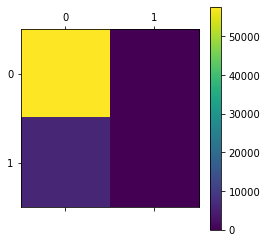

In [27]:
plt.matshow(cf)
plt.colorbar()
plt.show()

In [28]:
print(cf)

[[57731     0]
 [ 6247     0]]
